In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import re
import time
import sys
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.downloader as api
import gensim
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import enchant
import joblib
import os
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
datasets = {
    "davidson" : pd.read_csv("literature\datasets\dt\labeled_data_all_2classes_only.csv", index_col=0),
    "hateval" : pd.read_csv("literature\\datasets\\hateval\\train_en.tsv", sep='\t', index_col=0),
    "ethos" : pd.read_csv("literature\\datasets\\ethos\\Ethos_Dataset_Binary.csv", sep=';')
}

In [3]:
# Dataset preprocess
datasets["davidson"] = datasets["davidson"].rename({"tweet":"text"}, axis=1)
datasets["davidson"]['class'] = datasets["davidson"]['class'].replace({0: 1, 2: 0})

datasets["hateval"] = datasets["hateval"].rename({"HS":"class"}, axis=1)

datasets["ethos"] = datasets["ethos"].rename({"comment":"text", "isHate":"class"}, axis=1)
datasets["ethos"]['class'] = datasets["ethos"]['class'].astype("int")

In [4]:
def pre_process(data):
    df_pm = data.lower()
    return df_pm
def sep_rem(data):
    df_pm = data
    # df_pm = re.sub(r"[-()\"/;:<>{}`+=~|.!?,]", "", df_pm)
    df_pm = re.sub(r"[^a-zA-Z0-9#@ ]","",df_pm)
    return df_pm.strip()
def remove_hashtag(data):
    df_pm = re.sub(r"#\S+", "", data)
    return df_pm.strip()
def remove_mentions(data):
    data = re.sub(r"@\S+", "", data)
    return data.strip()
def remove_NCR(data):
    data = re.sub(r"&#[0-9]+;|&#x[0-9a-fA-F]+;|&[a-zA-Z]+", "", data)
    return data.strip()
def remove_RT(data):
    data = re.sub(r"(^|\s)rt\s", "", data)
    return data.strip()
def remove_links(data):
    data = re.sub(r"https?://(?:[\w./])+", " ", data)
    data = re.sub(r"http?://(?:[\w./&#])+", " ", data)
    return data.strip()
def remove_spaces(data):
    data = re.sub(r" +", " ", data)
    return data.strip()
    
d = enchant.Dict("en_US")

def spell_check_and_replace(text):
    # Tokenize the text into words
    words = np.array(text.split())
    
    # Create an empty array to store the misspelled mask
    misspelled_mask = np.zeros(len(words), dtype=bool)
    
    # Iterate through each word
    for i, word in enumerate(words):
        # Check if the word is misspelled
        if not d.check(word):
            # Update the misspelled mask
            misspelled_mask[i] = True
    
    # Get suggestions for misspelled words
    misspelled_words = words[misspelled_mask]
    suggestions = [d.suggest(word) for word in misspelled_words]
    
    # Replace misspelled words with the first suggestion
    for i, suggestion_list in enumerate(suggestions):
        if suggestion_list:
            misspelled_word_index = np.where(words == misspelled_words[i])[0][0]
            words[misspelled_word_index] = suggestion_list[0]
    
    # Join the corrected words back into a single string
    corrected_text = ' '.join(words)
    
    return corrected_text
def process_data(df):
    processed_column = df['text']
    processed_column = processed_column.apply(lambda x:pre_process(x))
    processed_column = processed_column.apply(lambda x:remove_links(x))
    processed_column = processed_column.apply(lambda x:remove_NCR(x))
    processed_column = processed_column.apply(lambda x:remove_hashtag(x))
    processed_column = processed_column.apply(lambda x:remove_mentions(x))
    processed_column = processed_column.apply(lambda x:sep_rem(x))
    processed_column = processed_column.apply(lambda x:remove_RT(x))
    processed_column = processed_column.apply(lambda x:remove_spaces(x))
    # processed_column = processed_column.apply(lambda x:spell_check_and_replace(x))
    df["clean"] = processed_column
    return df

In [5]:
datasets["davidson"] = process_data(datasets["davidson"])
datasets["hateval"] = process_data(datasets["hateval"])
datasets["ethos"] = process_data(datasets["ethos"])

class
0    23353
1     1430
Name: count, dtype: int64


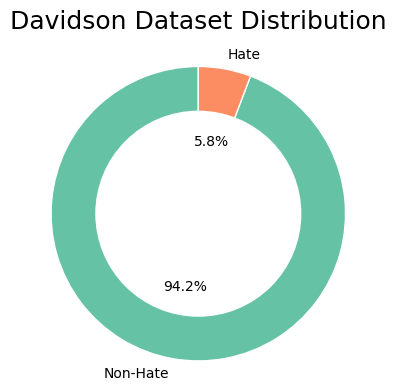

In [6]:
class_distribution = datasets["davidson"]['class'].value_counts()
print(class_distribution)
# Define colors
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=["Non-Hate", "Hate"], autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(edgecolor='w'),pctdistance=0.5)

# Add a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Davidson Dataset Distribution', fontsize=18, color='black', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


class
0    5217
1    3783
Name: count, dtype: int64


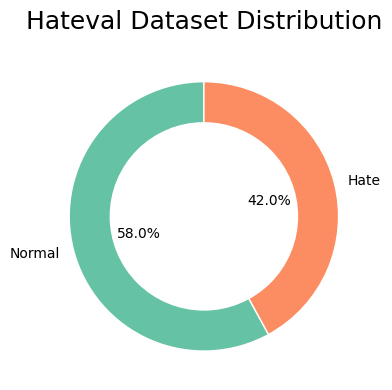

In [7]:
class_distribution = datasets["hateval"]['class'].value_counts()
print(class_distribution)

plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=["Normal", "Hate"], autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(edgecolor='w'),pctdistance=0.5)

# Add a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Hateval Dataset Distribution', fontsize=18, color='black', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


class
0    835
1    163
Name: count, dtype: int64


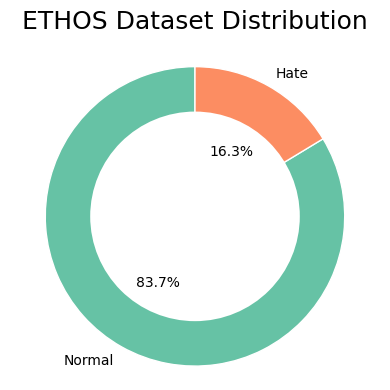

In [8]:
class_distribution = datasets["ethos"]['class'].value_counts()
print(class_distribution)
plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=["Normal", "Hate"], autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(edgecolor='w'),pctdistance=0.5)

# Add a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('ETHOS Dataset Distribution', fontsize=18, color='black', y=1.05)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

[24783, 9000, 998]


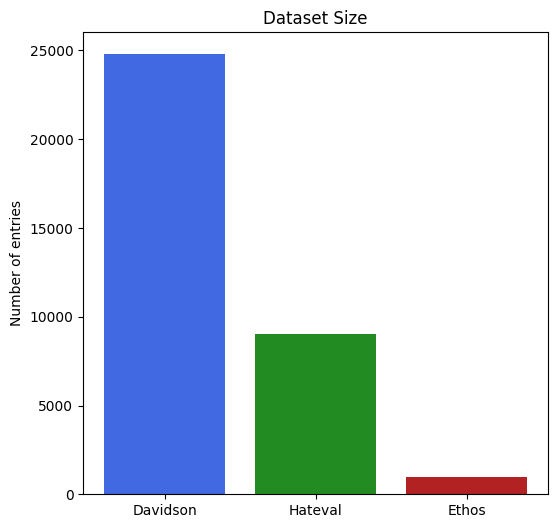

In [9]:
data1 = [23353,5217,835]
data2 = [1430, 3783, 163]

print([len(datasets["davidson"]),len(datasets["hateval"]),len(datasets["ethos"])])
plt.figure(figsize=(6, 6))
plt.bar([0,1,2],[len(datasets["davidson"]),len(datasets["hateval"]),len(datasets["ethos"])], color=['royalblue', 'forestgreen', 'firebrick'])
plt.title('Dataset Size')
plt.xticks([0,1,2], ["Davidson", "Hateval", "Ethos"])
plt.ylabel("Number of entries")
plt.show()

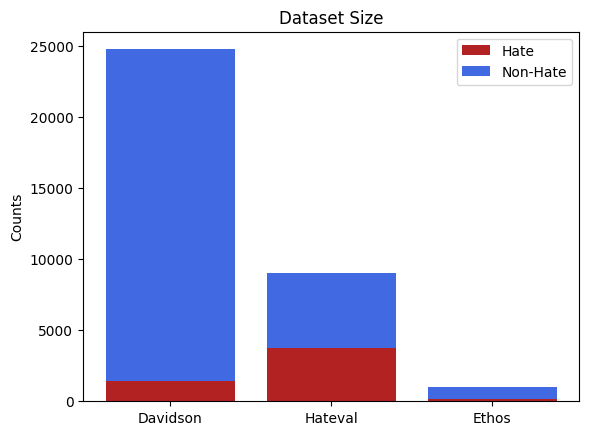

In [21]:
data1 = [23353, 5217, 835]
data2 = [1430, 3783, 163]

labels = ["Davidson", "Hateval", "Ethos"]
x = np.arange(len(labels))

fig, ax = plt.subplots()

# Plotting data2 first (bottom)
ax.bar(x, data2, label='Hate', color=["firebrick"])

# Plotting data1 on top of data2
ax.bar(x, data1, bottom=data2, label='Non-Hate', color=["royalblue"])

ax.set_ylabel('Counts')
ax.set_title('Dataset Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

{'Davidson': 85.43606504458701, 'Hateval': 139.99844444444443, 'Ethos': 111.97094188376754}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Portul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


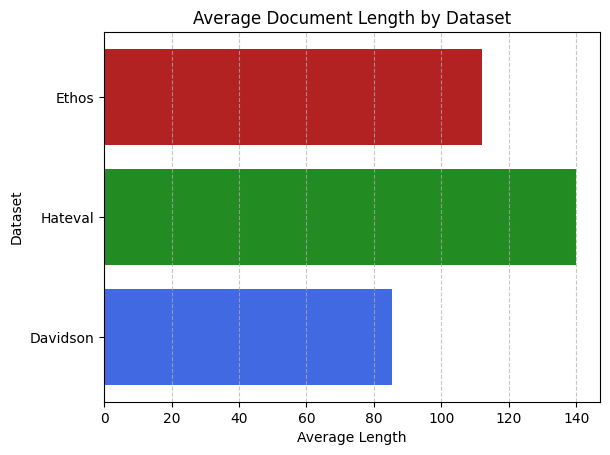

In [11]:
total_length_d = sum(len(doc) for doc in datasets["davidson"]["text"]) / len(datasets["davidson"]["text"])
total_length_h = sum(len(doc) for doc in datasets["hateval"]["text"]) / len(datasets["hateval"]["text"])
total_length_e = sum(len(doc) for doc in datasets["ethos"]["text"]) / len(datasets["ethos"]["text"])
average_lengths = {
    "Davidson": total_length_d,
    "Hateval": total_length_h,
    "Ethos": total_length_e
}
print(average_lengths)
plt.barh(range(len(average_lengths)), list(average_lengths.values()), color=['royalblue', 'forestgreen', 'firebrick'])
plt.xlabel('Average Length')
plt.ylabel('Dataset')
plt.title('Average Document Length by Dataset')

from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

nltk.download('punkt')
plt.yticks(range(len(average_lengths)), list(average_lengths.keys()))
plt.grid(axis='x', linestyle='--', alpha=0.7)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Portul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Portul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


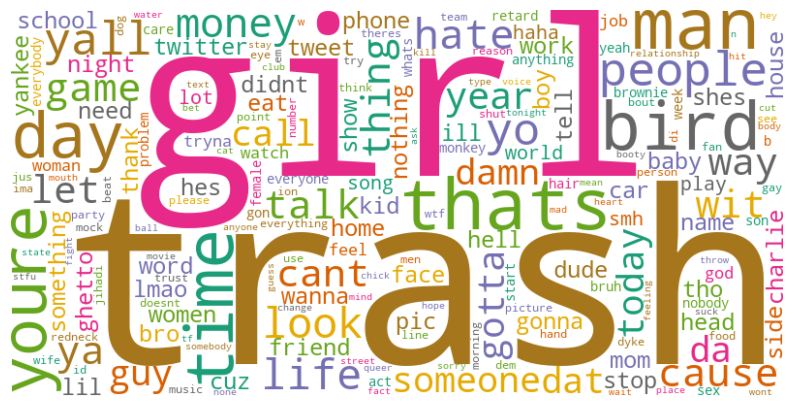

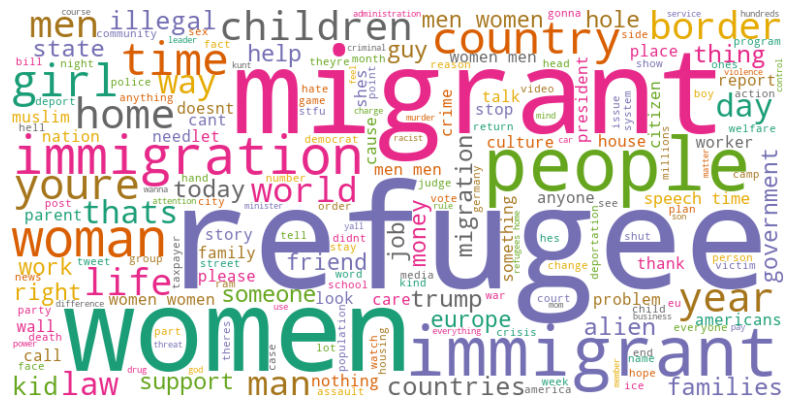

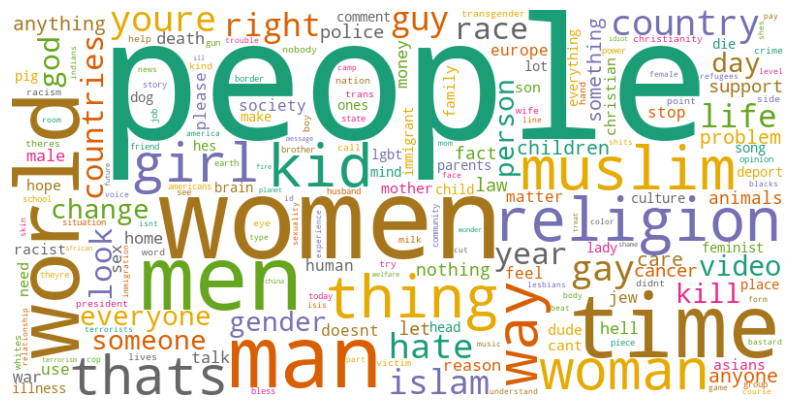

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Get NLTK English stopwords
nltk_stopwords = set(stopwords.words('english'))

# List of profane words (replace this with your own list)
profane_words = ["crackers","coon","faggots","ho","cock","pussies","niggah","fuckin","fag","niggers","cracker","rape","like","dont","get","got","aint","lol","know","one","love","im","hoes","bitches","skank","ass","dick","fuck","niggas","nicca","faggot","retarded","bitch","rt","hoe","https","t","co","shit","fucking","cunt","Bitch","whore","slut","u","pussy","nigga","nigger"]

words_to_filter = profane_words + list(nltk_stopwords)

# Function to remove profane words from text and convert to lowercase
def preprocess_text(text, profane_words):
    # Split the text into words
    text = text.lower()
    words = text.split()
    # Remove profane words and convert to lowercase
    words = [word.lower() for word in words if word.lower() not in words_to_filter]

    tagged_words = pos_tag(words)
    words = [word for word, pos in tagged_words if pos.startswith('N')]
    # Join the words back into a single string
    return ' '.join(words)

# Function to generate and display word cloud
def generate_wordcloud(data, dataset_name):
    # Concatenate all strings in the dataset
    text = ' '.join(data)
    # Preprocess text
    text = preprocess_text(text, profane_words)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    # plt.title('Word Cloud for ' + dataset_name)
    plt.show()


generate_wordcloud(datasets["davidson"]["clean"], "Davidson")
generate_wordcloud(datasets["hateval"]["clean"], "Hateval")
generate_wordcloud(datasets["ethos"]["clean"], "Ethos")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Portul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Portul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('bitch', 7073), ('bitches', 2925), ('hoes', 2078), ('ass', 1443), ('hoe', 1423), ('im', 1259), ('dont', 959), ('pussy', 905), ('aint', 776), ('trash', 717), ('thats', 575), ('fuck', 542), ('lol', 540), ('man', 510), ('youre', 509), ('shit', 462), ('nigga', 446), ('time', 438), ('niggas', 412), ('people', 410), ('yall', 365), ('get', 351), ('yo', 341), ('day', 334), ('hate', 323), ('bird', 319), ('life', 289), ('girl', 289), ('money', 277), ('look', 269), ('girls', 269), ('cant', 269), ('wit', 254), ('talk', 249), ('cause', 247), ('love', 240), ('ya', 236), ('cunt', 227), ('way', 218), ('gotta', 218), ('damn', 211), ('birds', 209), ('game', 208), ('da', 207), ('today', 204), ('u', 194), ('call', 192), ('lmao', 187), ('dat', 185), ('gonna', 185)]


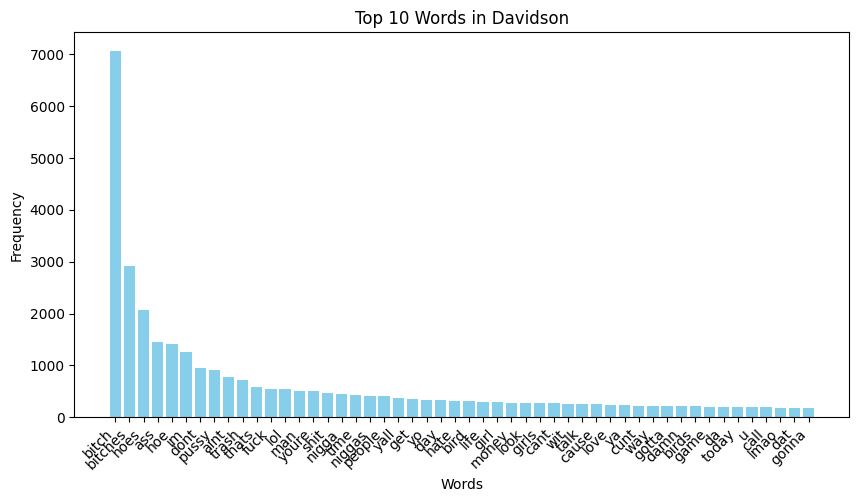

[('bitch', 926), ('women', 834), ('refugees', 730), ('men', 505), ('people', 494), ('migrants', 481), ('immigration', 472), ('woman', 461), ('cunt', 425), ('immigrants', 361), ('rape', 359), ('time', 335), ('dont', 303), ('country', 299), ('youre', 294), ('ass', 271), ('home', 237), ('children', 228), ('hoe', 210), ('im', 201), ('refugee', 197), ('whore', 190), ('life', 181), ('world', 180), ('girl', 180), ('man', 177), ('trump', 154), ('immigrant', 146), ('countries', 140), ('thats', 140), ('border', 140), ('way', 133), ('year', 130), ('kids', 127), ('illegals', 121), ('migration', 121), ('families', 120), ('someone', 114), ('help', 113), ('rights', 113), ('fuck', 113), ('dick', 113), ('today', 112), ('skank', 112), ('support', 111), ('speech', 108), ('day', 105), ('years', 101), ('girls', 101), ('law', 100)]


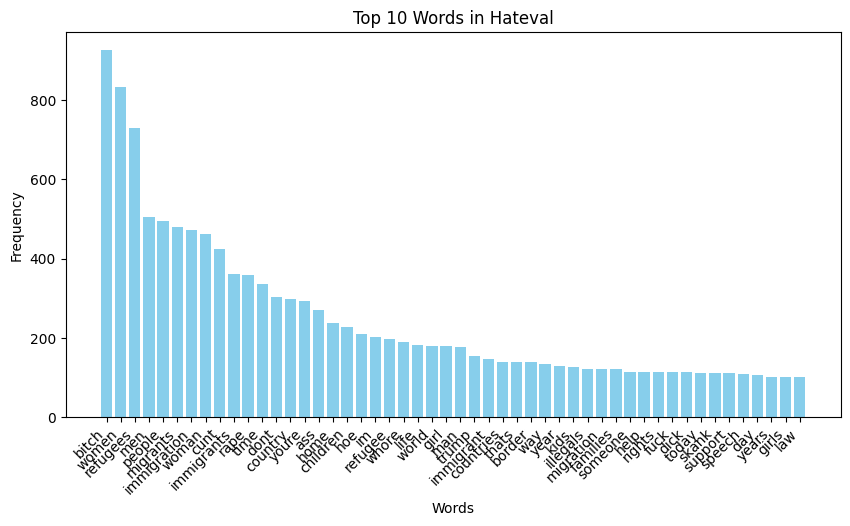

[('people', 198), ('women', 69), ('dont', 46), ('men', 42), ('world', 39), ('man', 36), ('ass', 36), ('time', 34), ('im', 34), ('woman', 30), ('religion', 29), ('muslims', 29), ('way', 28), ('thats', 26), ('country', 25), ('thing', 25), ('kids', 23), ('youre', 23), ('islam', 22), ('life', 20), ('hate', 20), ('countries', 18), ('kill', 18), ('bitch', 18), ('rights', 17), ('gay', 17), ('look', 16), ('love', 16), ('god', 15), ('girls', 15), ('race', 15), ('everyone', 15), ('care', 15), ('someone', 15), ('anything', 14), ('change', 14), ('person', 14), ('children', 14), ('something', 14), ('police', 13), ('shit', 13), ('cancer', 13), ('get', 13), ('anyone', 13), ('support', 13), ('video', 13), ('guys', 13), ('nothing', 12), ('animals', 12), ('girl', 12)]


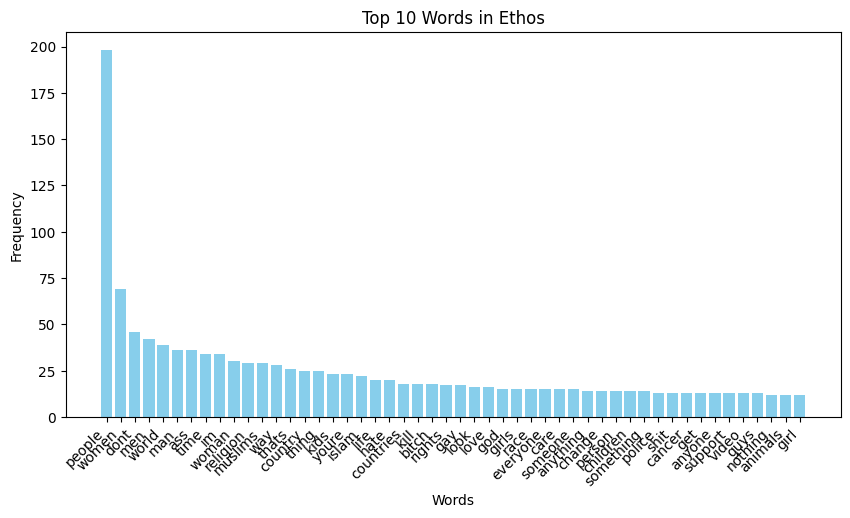

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Get NLTK English stopwords
nltk_stopwords = set(stopwords.words('english'))
# Function to get the top n words in the text
profane_words = ["fag","rape","like","dont","get","got","aint","lol","know","one","love","im","hoes","bitches","skank","ass","dick","fuck","niggas","nicca","faggot","retarded","bitch","rt","hoe","https","t","co","shit","fucking","cunt","Bitch","whore","slut","u","pussy","nigga","nigger"]

words_to_filter = list(nltk_stopwords)
# words_to_filter = profane_words + list(nltk_stopwords)

def get_top_words(text, n=50):
    text = ' '.join(text)
    # Split the text into words
    words = text.split()
    words = [word.lower() for word in words if word.lower() not in words_to_filter]

    tagged_words = pos_tag(words)
    words = [word for word, pos in tagged_words if pos.startswith('N')]
    # Count the frequency of each word
    word_freq = Counter(words)
    # Get the top n most frequent words
    top_words = word_freq.most_common(n)
    return top_words

# Function to generate and display bar plot for top words
def plot_top_words(top_words, dataset_name):
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Words in ' + dataset_name)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Example usage:
top_words = get_top_words(datasets["davidson"]["clean"].tolist())
print(top_words)
plot_top_words(top_words, "Davidson")
top_words = get_top_words(datasets["hateval"]["clean"].tolist())
print(top_words)
plot_top_words(top_words, "Hateval")
top_words = get_top_words(datasets["ethos"]["clean"].tolist())
print(top_words)
plot_top_words(top_words, "Ethos")

In [64]:
TFIDF_SVM = [0.91, 0.66, 0.76]
BOW_SVM = [0.9, 0.69, 0.76]
W2V_SVM = [0.82, 0.59, 0.71]
TFIDF_NB = [0.91,0.68, 0.76]
BOW_NB = [0.91,0.65, 0.78]
TFIDF_LR = [0.91,0.69, 0.76]
BOW_LR = [0.91,0.68, 0.77]
W2V_LR = [0.83,0.62, 0.72]
W2V_DL = [0.93, 0.74, 0.78]

time_to_train = [1.897, 3.091, 14.863]
memory = [170609 , 680221, 170677]

In [23]:
TFIDF_SVM = {
    "Precision": ["0.3", "0.69", "0.35"],
    "Recall": ["0.62", "0.7", "0.5"],
    "F1 micro": ["0.41", "0.69", "0.35"],
    "F1 macro": ["0.68", "0.73", "0.63"],
    "CV F1": ["0.91", "0.66", "0.76"]
}

BOW_SVM = {
    "Precision": ["0.28", "0.71", "0.35"],
    "Recall": ["0.64", "0.67", "0.36"],
    "F1 micro": ["0.28", "0.71", "0.35"],
    "F1 macro": ["0.66", "0.74", "0.6"],
    "CV F1": ["0.9", "0.69", "0.76"]
}

W2V_SVM = {
    "Precision": ["0.14", "0.54", "0.18"],
    "Recall": ["0.64", "0.55", "0.27"],
    "F1 micro": ["0.23", "0.55", "0.21"],
    "F1 macro": ["0.55", "0.6", "0.52"],
    "CV F1": ["0.82", "0.59", "0.71"]
}

TFIDF_NB = {
    "Precision": ["0.6", "0.74", "0.0"],
    "Recall": ["0.01", "0.57", "0.0"],
    "F1 micro": ["0.01", "0.64", "0.0"],
    "F1 macro": ["0.49", "0.71", "0.46"],
    "CV F1": ["0.91", "0.68", "0.76"]
}

BOW_NB = {
    "Precision": ["0.1", "0.64", "0.33"],
    "Recall": ["0.03", "0.7", "0.13"],
    "F1 micro": ["0.05", "0.67", "0.18"],
    "F1 macro": ["0.51", "0.7", "0.54"],
    "CV F1": ["0.91", "0.65", "0.78"]
}

TFIDF_LR = {
    "Precision": ["0.28", "0.69", "0.39"],
    "Recall": ["0.56", "0.7", "0.4"],
    "F1 micro": ["0.38", "0.7", "0.4"],
    "F1 macro": ["0.66", "0.73", "0.63"],
    "CV F1": ["0.91", "0.69", "0.76"]
}

BOW_LR = {
    "Precision": ["0.29", "0.69", "0.28"],
    "Recall": ["0.53", "0.68", "0.24"],
    "F1 micro": ["0.37", "0.69", "0.26"],
    "F1 macro": ["0.66", "0.73", "0.55"],
    "CV F1": ["0.91", "0.68", "0.77"]
}

W2V_LR = {
    "Precision": ["0.16", "0.62", "0.28"],
    "Recall": ["0.64", "0.62", "0.79"],
    "F1 micro": ["0.26", "0.62", "0.41"],
    "F1 macro": ["0.56", "0.67", "0.6"],
    "CV F1": ["0.83", "0.62", "0.72"]
}


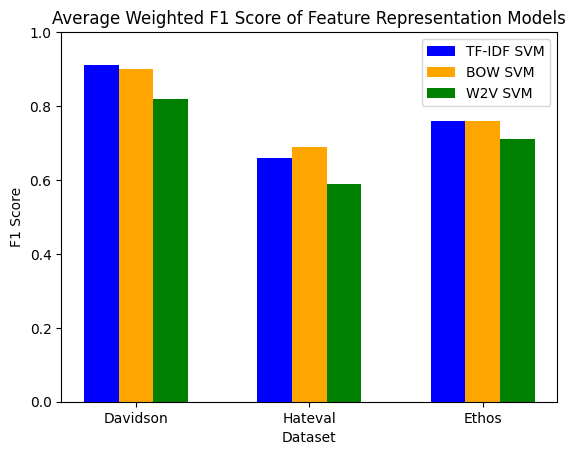

In [25]:
cv_f1_tfidf = [float(value) for value in TFIDF_SVM["CV F1"]]
cv_f1_bow = [float(value) for value in BOW_SVM["CV F1"]]
cv_f1_w2v = [float(value) for value in W2V_SVM["CV F1"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, cv_f1_tfidf, width=bar_width, label='TF-IDF SVM', color='blue')
plt.bar([i + bar_width for i in x], cv_f1_bow, width=bar_width, label='BOW SVM', color='orange')
plt.bar([i + 2 * bar_width for i in x], cv_f1_w2v, width=bar_width, label='W2V SVM', color='green')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('Average Weighted F1 Score of Feature Representation Models')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

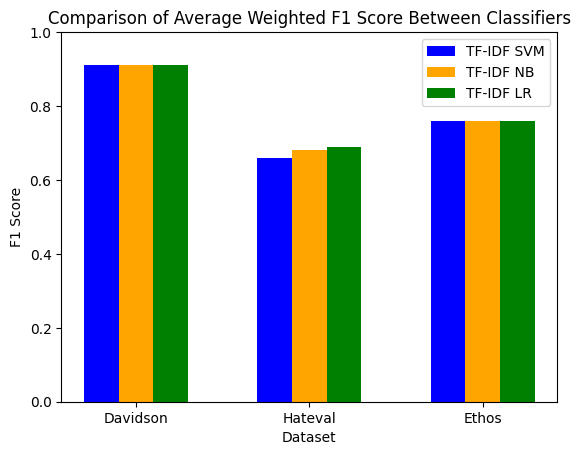

In [162]:
tfidf_svm = [float(value) for value in TFIDF_SVM["CV F1"]]
tfidf_nv = [float(value) for value in TFIDF_NB["CV F1"]]
tfidf_lr = [float(value) for value in TFIDF_LR["CV F1"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, tfidf_svm, width=bar_width, label='TF-IDF SVM', color='blue')
plt.bar([i + bar_width for i in x], tfidf_nv, width=bar_width, label='TF-IDF NB', color='orange')
plt.bar([i + 2 * bar_width for i in x], tfidf_lr, width=bar_width, label='TF-IDF LR', color='green')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('Comparison of Average Weighted F1 Score Between Classifiers')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

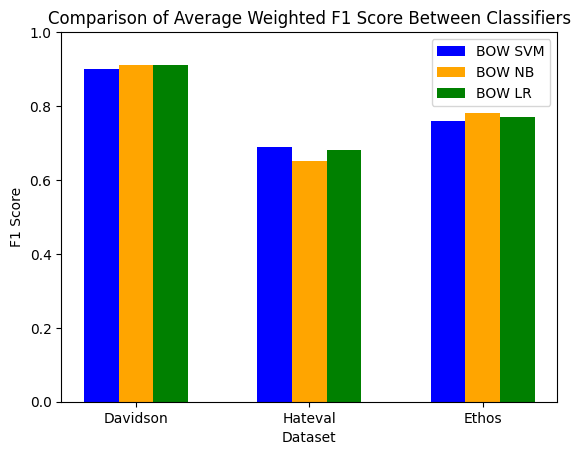

In [91]:
tfidf_svm = [float(value) for value in BOW_SVM["CV F1"]]
tfidf_nv = [float(value) for value in BOW_NB["CV F1"]]
tfidf_lr = [float(value) for value in BOW_LR["CV F1"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, tfidf_svm, width=bar_width, label='BOW SVM', color='blue')
plt.bar([i + bar_width for i in x], tfidf_nv, width=bar_width, label='BOW NB', color='orange')
plt.bar([i + 2 * bar_width for i in x], tfidf_lr, width=bar_width, label='BOW LR', color='green')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('Comparison of Average Weighted F1 Score Between Classifiers')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

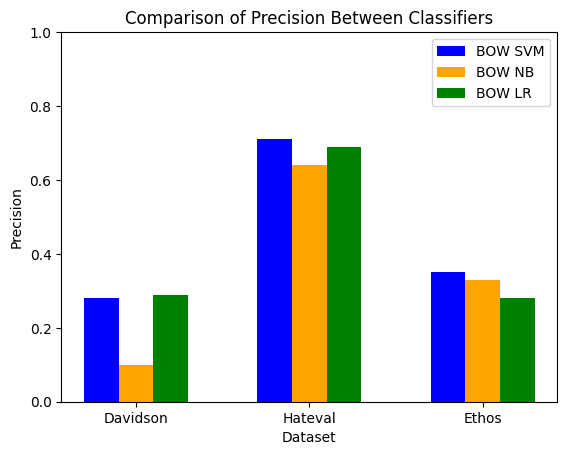

In [26]:
tfidf_svm = [float(value) for value in BOW_SVM["Precision"]]
tfidf_nv = [float(value) for value in BOW_NB["Precision"]]
tfidf_lr = [float(value) for value in BOW_LR["Precision"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, tfidf_svm, width=bar_width, label='BOW SVM', color='blue')
plt.bar([i + bar_width for i in x], tfidf_nv, width=bar_width, label='BOW NB', color='orange')
plt.bar([i + 2 * bar_width for i in x], tfidf_lr, width=bar_width, label='BOW LR', color='green')
plt.xlabel('Dataset')
plt.ylabel('Precision')
plt.title('Comparison of Precision Between Classifiers')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

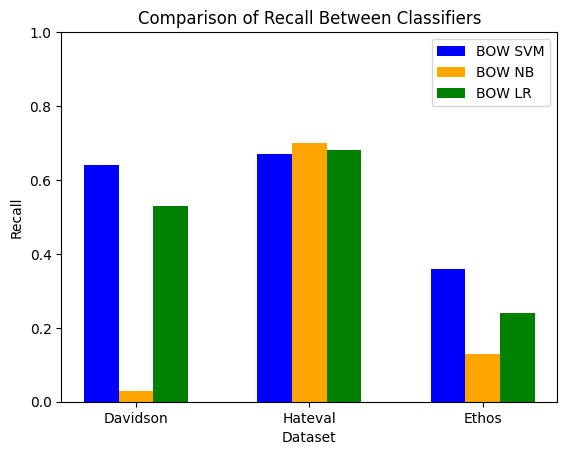

In [92]:
tfidf_svm = [float(value) for value in BOW_SVM["Recall"]]
tfidf_nv = [float(value) for value in BOW_NB["Recall"]]
tfidf_lr = [float(value) for value in BOW_LR["Recall"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, tfidf_svm, width=bar_width, label='BOW SVM', color='blue')
plt.bar([i + bar_width for i in x], tfidf_nv, width=bar_width, label='BOW NB', color='orange')
plt.bar([i + 2 * bar_width for i in x], tfidf_lr, width=bar_width, label='BOW LR', color='green')
plt.xlabel('Dataset')
plt.ylabel('Recall')
plt.title('Comparison of Recall Between Classifiers')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

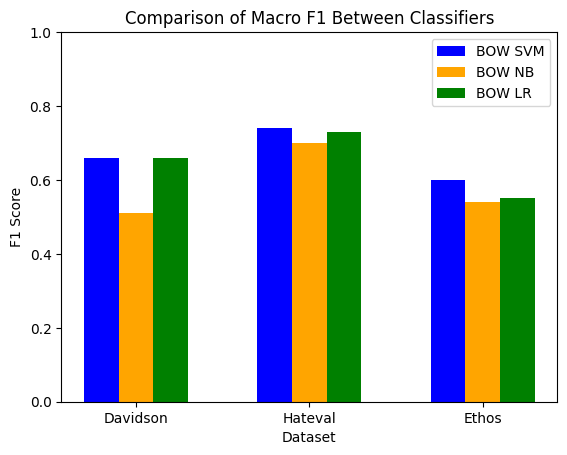

In [93]:
tfidf_svm = [float(value) for value in BOW_SVM["F1 macro"]]
tfidf_nv = [float(value) for value in BOW_NB["F1 macro"]]
tfidf_lr = [float(value) for value in BOW_LR["F1 macro"]]

# Bar plot
labels = ['Davidson', 'Hateval', 'Ethos']
x = range(len(labels))
bar_width = 0.2  # Width of each bar
plt.bar(x, tfidf_svm, width=bar_width, label='BOW SVM', color='blue')
plt.bar([i + bar_width for i in x], tfidf_nv, width=bar_width, label='BOW NB', color='orange')
plt.bar([i + 2 * bar_width for i in x], tfidf_lr, width=bar_width, label='BOW LR', color='green')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.title('Comparison of Macro F1 Between Classifiers')
plt.xticks([i + bar_width for i in x], labels)
plt.legend()
plt.ylim(0, 1.0)
plt.show()

[0.91, 0.9, 0.82, 0.91, 0.91, 0.91, 0.91, 0.83]


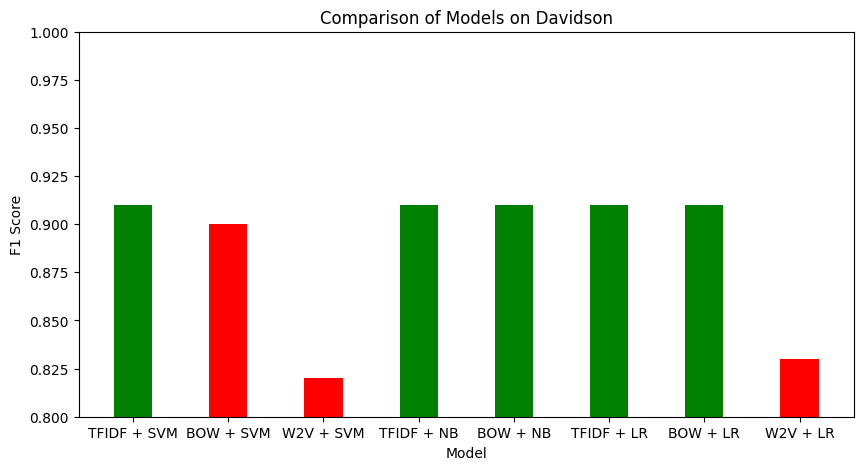

In [120]:
ds = 0
tfidf_svm = [TFIDF_SVM["CV F1"][ds], BOW_SVM["CV F1"][ds],W2V_SVM["CV F1"][ds], TFIDF_NB["CV F1"][ds],BOW_NB["CV F1"][ds], TFIDF_LR["CV F1"][ds], BOW_LR["CV F1"][ds], W2V_LR["CV F1"][ds]]
tfidf_svm = [float(score) for score in tfidf_svm]
print(tfidf_svm)

# Bar plot
labels = ["TFIDF + SVM","BOW + SVM","W2V + SVM","TFIDF + NB","BOW + NB","TFIDF + LR","BOW + LR","W2V + LR"]
x = range(len(labels))
bar_width = 0.4  # Width of each bar
plt.figure(figsize=(10, 5))
plt.bar(x, tfidf_svm, width=bar_width, color=["g","r","r","g","g","g","g","r"])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Models on Davidson')
plt.xticks(x, labels)
plt.ylim(0.8,1)
plt.show()

[0.66, 0.69, 0.59, 0.68, 0.65, 0.69, 0.68, 0.62]


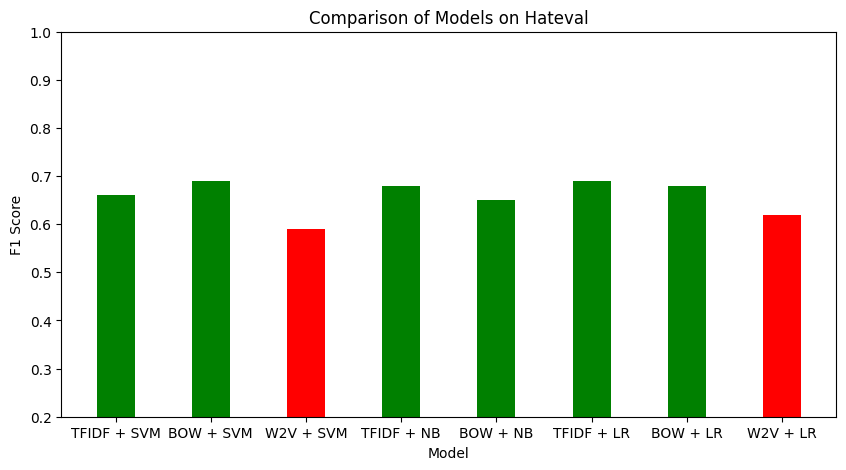

In [125]:
ds = 1
tfidf_svm = [TFIDF_SVM["CV F1"][ds], BOW_SVM["CV F1"][ds],W2V_SVM["CV F1"][ds], TFIDF_NB["CV F1"][ds],BOW_NB["CV F1"][ds], TFIDF_LR["CV F1"][ds], BOW_LR["CV F1"][ds], W2V_LR["CV F1"][ds]]
tfidf_svm = [float(score) for score in tfidf_svm]
print(tfidf_svm)

# Bar plot
labels = ["TFIDF + SVM","BOW + SVM","W2V + SVM","TFIDF + NB","BOW + NB","TFIDF + LR","BOW + LR","W2V + LR"]
x = range(len(labels))
bar_width = 0.4  # Width of each bar
plt.figure(figsize=(10, 5))
plt.bar(x, tfidf_svm, width=bar_width, color=["g","g","r","g","g","g","g","r"])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Models on Hateval')
plt.xticks(x, labels)
plt.ylim(0.2,1)
plt.show()

[0.76, 0.76, 0.71, 0.76, 0.78, 0.76, 0.77, 0.72]


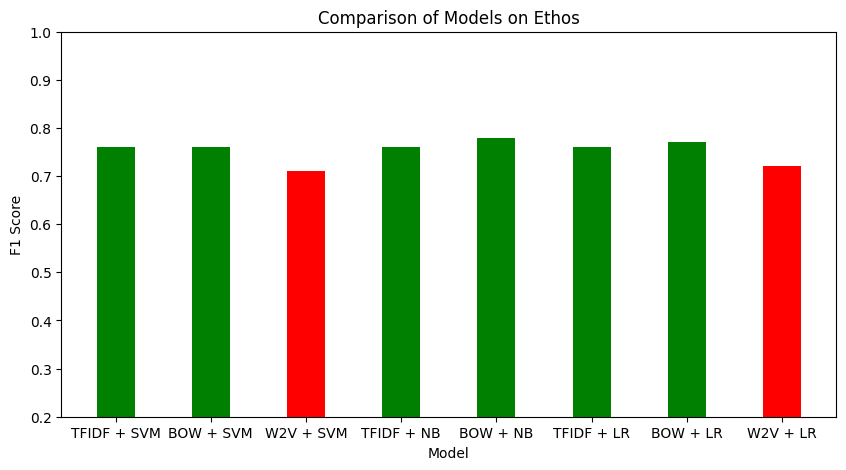

In [124]:
ds = 2
tfidf_svm = [TFIDF_SVM["CV F1"][ds], BOW_SVM["CV F1"][ds],W2V_SVM["CV F1"][ds], TFIDF_NB["CV F1"][ds],BOW_NB["CV F1"][ds], TFIDF_LR["CV F1"][ds], BOW_LR["CV F1"][ds], W2V_LR["CV F1"][ds]]
tfidf_svm = [float(score) for score in tfidf_svm]
print(tfidf_svm)

# Bar plot
labels = ["TFIDF + SVM","BOW + SVM","W2V + SVM","TFIDF + NB","BOW + NB","TFIDF + LR","BOW + LR","W2V + LR"]
x = range(len(labels))
bar_width = 0.4  # Width of each bar
plt.figure(figsize=(10, 5))
plt.bar(x, tfidf_svm, width=bar_width, color=["g","g","r","g","g","g","g","r"])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Models on Ethos')
plt.xticks(x, labels)
plt.ylim(0.2,1)
plt.show()